# TF reporter activity analysis
### Aim
~36,000 reporters for 86 TFs were transfected into 9 different cell types & tested in 97 different perturbation conditions. In this script I will analyze TF reporter activities in detail and review how individual reporters respond to TF concentration variations.

### Figure 4 - Reviewing TF specificity by characterizing reporter activities across cell types and upoun TF perturbations

---
Load libraries

In [2]:
# Load libraries:
import matplotlib.pyplot as plt  # Equivalent to RColorBrewer and ggplot2
import pandas as pd  # Equivalent to dplyr, tibble, and readr
pd.set_option('display.max_columns', None)  # Show all columns
import seaborn as sns  # Equivalent to pheatmap and ggpubr
import plotly  # Equivalent to plotly
import numpy as np  # Equivalent to maditr
import string  # Equivalent to stringr
import re  # Equivalent to stringr
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_1776337/808305366.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd  # Equivalent to dplyr, tibble, and readr


---
**Load data**

In [3]:
# Import RNA-seq correlation data
rna_correlations_df = pd.read_csv('/DATA/usr/m.trauernicht/projects/SuRE-TF/data/rna_correlations_df.tsv', sep='\t')

rna_correlations_df

,tf,reporter_activity_minP,cell,reporter_id,commercial_reporter,spacing,promoter,background,distance,TPM,TPM_norm,nTPM,cor_pval,cor,cor_pval_fdr,min_TPM,max_TPM,dif_TPM,mean_tf_activity,max_mean_tf_activity,reasonable
0,AHR::ARNT,0.356408,A549,AHR::ARNT_10bp_10bp_mCMV_1,No,10bp,mCMV,1.0,10bp,7.400000,10.717241,6.537605,-0.000000,-0.223189,-0.000000,0.107888,20.843715,20.735828,0.642315,0.796163,Yes
1,AHR::ARNT,-0.212790,HCT116,AHR::ARNT_10bp_10bp_mCMV_1,No,10bp,mCMV,1.0,10bp,9.000000,12.600000,9.413165,-0.000000,-0.223189,-0.000000,0.107888,20.843715,20.735828,0.740889,0.796163,Yes
2,AHR::ARNT,0.388086,HEK293,AHR::ARNT_10bp_10bp_mCMV_1,No,10bp,mCMV,1.0,10bp,3.100000,4.068750,2.982113,-0.000000,-0.223189,-0.000000,0.107888,20.843715,20.735828,0.796163,0.796163,Yes
3,AHR::ARNT,0.226050,HepG2,AHR::ARNT_10bp_10bp_mCMV_1,No,10bp,mCMV,1.0,10bp,11.100000,17.930769,8.912570,-0.000000,-0.223189,-0.000000,0.107888,20.843715,20.735828,0.553665,0.796163,Yes
4,AHR::ARNT,0.427850,K562,AHR::ARNT_10bp_10bp_mCMV_1,No,10bp,mCMV,1.0,10bp,0.200000,0.336000,0.192302,-0.000000,-0.223189,-0.000000,0.107888,20.843715,20.735828,0.393107,0.796163,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26028,ZFX,0.265156,K562,ZFX_5bp_21bp_minP_3,No,5bp,minP,3.0,21bp,11.200000,18.816000,10.768924,1.251415,0.653960,0.673612,5.459953,51.980905,46.520952,-0.274812,0.354680,Yes
26029,ZFX,-0.157797,MCF7,ZFX_5bp_21bp_minP_3,No,5bp,minP,3.0,21bp,6.600000,10.661538,5.913701,1.251415,0.653960,0.673612,5.459953,51.980905,46.520952,-0.216655,0.354680,Yes
26030,ZFX,0.488114,mES,ZFX_5bp_21bp_minP_3,No,5bp,minP,3.0,21bp,37.584038,220.240024,51.980905,1.251415,0.653960,0.673612,5.459953,51.980905,46.520952,0.354680,0.354680,Yes
26031,ZFX,0.310797,NPC,ZFX_5bp_21bp_minP_3,No,5bp,minP,3.0,21bp,14.840401,174.596102,16.174899,1.251415,0.653960,0.673612,5.459953,51.980905,46.520952,0.185418,0.354680,Yes


### Plot activities across different cell types
Aim: How cell type-specific are the TF reporters?

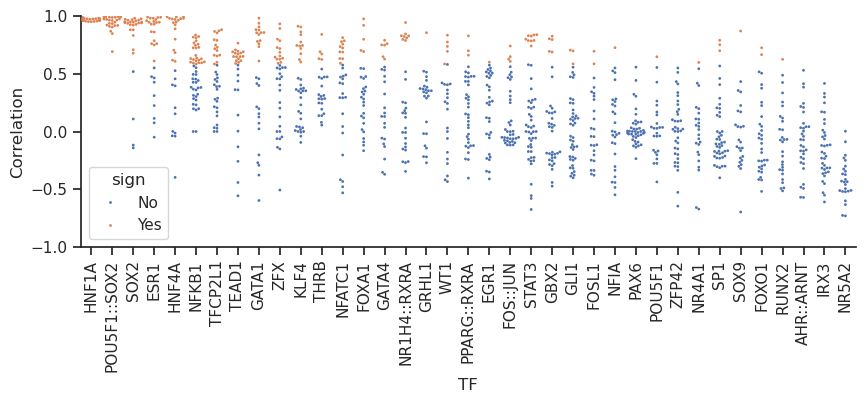

In [4]:
# Filter the dataframe
filtered_df = rna_correlations_df[rna_correlations_df['reasonable'] == 'Yes']
filtered_df = filtered_df[['reporter_id', 'cor_pval', 'cor', 'tf', 'commercial_reporter']].drop_duplicates()

# Add a new column 'sign'
filtered_df['sign'] = ['Yes' if pval > 1 else 'No' for pval in filtered_df['cor_pval']]

# Calculate mean correlation per TF
filtered_df['mean_cor'] = filtered_df.groupby('tf')['cor'].transform('mean')

# Plot the data, combine swarmplot and violinplot
plt.figure(figsize=(10, 3))
## Remove grid
sns.set(style='ticks')
## Create swarmplot, color matches p-value
sns.swarmplot(x='tf', y='cor', data=filtered_df, order=filtered_df.groupby('tf')['mean_cor'].mean().sort_values(ascending=False).index, hue = 'sign', size=2, dodge=False)
plt.ylim(-1, 1)
plt.xticks(rotation=90)
sns.despine()
## Set axis labels
plt.xlabel('TF')
plt.ylabel('Correlation')
## Save figure to pdf
plt.savefig('/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/rna_correlations_swarmplot.pdf', bbox_inches='tight')
plt.show();